# IEOR 165 Final Project

The authors of the following research paper: Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis, “Modeling wine preferences by data mining from physicochemical properties”,Decision Support Systems, vol. 47, no. 4:547-553, 2009. considered  the  problem  of  modeling  wine  preferences.   

Wine can be evaluated by experts who give a subjective score, and the question the authors of this paper considered was how to build a model that relates objective features of the wine (e.g. pH values) to its rated quality.

For this project, we will use the data set available at: http://courses.ieor.berkeley.edu/ieor165/homeworks/winequality-red.csv 

Use the following methods to identify the coefficients of a linear model relating wine quality to different features of the wine: (1) ordinary least squares (OLS), (2) ridge regression (RR), (3) lasso regression, (4) elastic net. Make sure to include a constant (intercept) term  in  your model, and choose the tuning parameters using cross-validation. You may use any programming language you would like to. For your solutions, please include (i) plots of tuning parameters versus cross-validation error, (ii) tables of coefficients (labeled by the feature) computed by eachmethod, (iii) the minimum cross-validation error for each method, and (iv) the source code used to generate the plots and coefficients.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import re
import seaborn as sns
from scipy import stats
import sklearn
import sklearn.datasets
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Loading Wine Data
Loading the data and splitting it into the predictor variables or features (X) and the response variable quality score (Y).
We then need to split the data into training and testing data so that we know how well our model is at predicting.

In [2]:
wine_data = pd.read_csv("winequality-red.csv")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
X = wine_data.iloc[:, 0:11]
Y = wine_data.iloc[:,11]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10)

# Ordinary Least Squares Model
Given by argmin(($ ||Y - Xbeta||^2_2)$and without any regularization.

I am using scikit learn machine learning library built in linear regression model fitting.

"LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation."
    From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [5]:
#fitting the model with built in intercept
ordinary_linear_model = linear_model.LinearRegression(fit_intercept=True)

ordinary_linear_model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
ols_coef = ordinary_linear_model.coef_
columns = X.columns
OLS_table = pd.DataFrame(columns=["feature", "coefficient"])
OLS_table["feature"]=columns
OLS_table["coefficient"]=ols_coef
ols_intercept = ordinary_linear_model.intercept_

In [7]:
#cross validation even though we aren't finding hyperparameters
scores = cross_val_score(ordinary_linear_model, X_train, Y_train, cv=10,scoring='neg_mean_squared_error')
scores = np.abs(scores)
ols_min_cv = min(scores)

In [8]:
#rounding predictions since they are only whole numbers
train_predictions = ordinary_linear_model.predict(X_train)
train_predictions = np.around(train_predictions, decimals=0)
train_predictions = train_predictions.astype(int)
test_predictions = ordinary_linear_model.predict(X_test)
test_predictions = np.around(test_predictions, decimals=0)
test_predictions = test_predictions.astype(int)

In [9]:
def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

In [10]:
ols_training_error=mse_cost(Y_train, train_predictions)
ols_test_error=mse_cost(Y_test, test_predictions)

# Ridge Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||^2_2 $ where alpha is the tuning parameter we will be finding using cross validation to minimize prediction error.

I am using scikit learn machine learning library built in ridge regression model fitting.

"This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm." From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

# Using kfold cross validation with k=10 to find best tuning parameter for Ridge

In [11]:
alphas=np.arange(-10,10,.1)
validation_errors =[]
for alpha in alphas:
    ridge_linear_model = Ridge(alpha=alpha, fit_intercept = True)
    scores = cross_val_score(ridge_linear_model, X_train,Y_train, cv=10,scoring='neg_mean_squared_error')
    validation_errors.append(np.mean(scores))
validation_errors=np.abs(validation_errors)

C:\Users\annaw\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


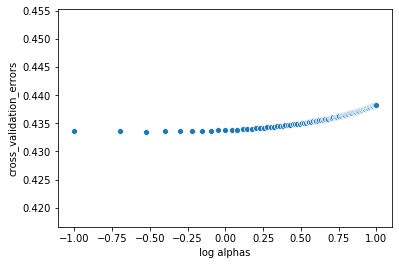

In [12]:
ridge_cv_table=pd.DataFrame(data=alphas)
ridge_cv_table = ridge_cv_table.rename({0:'alphas'},axis=1)
ridge_cv_table['cross_validation_errors']=validation_errors
ridge_min_cv = min(ridge_cv_table['cross_validation_errors'])
ridge_tuning = ridge_cv_table[ridge_cv_table['cross_validation_errors']==ridge_min_cv]['alphas'].values
ridge_cv_table['log alphas']=np.log10(alphas)
sns.scatterplot(x="log alphas",y="cross_validation_errors", data = ridge_cv_table)

In [13]:
final_ridge_linear_model = Ridge(fit_intercept = True, alpha=ridge_tuning)
final_ridge_linear_model.fit(X_train,Y_train)
ridge_coef = final_ridge_linear_model.coef_
ridge_intercept = final_ridge_linear_model.intercept_
columns = X.columns
ridge_table = pd.DataFrame(columns=["feature", "coefficient"])
ridge_table["feature"]=columns
ridge_table["coefficient"]=ridge_coef

In [14]:
#rounding predictions since they are only whole numbers
train_predictions = final_ridge_linear_model.predict(X_train)
train_predictions = np.around(train_predictions, decimals=0)
train_predictions = train_predictions.astype(int)
test_predictions = final_ridge_linear_model.predict(X_test)
test_predictions = np.around(test_predictions, decimals=0)
test_predictions = test_predictions.astype(int)
ridge_training_error=mse_cost(Y_train, train_predictions)
ridge_test_error=mse_cost(Y_test, test_predictions)

# Lasso Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||_1 $ where alpha is the tuning parameter we will be finding using cross validation to minimize prediction error.

I am using scikit learn machine learning library built in lasso regression model fitting. From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

# Using kfold cross validation with k=10 to find best tuning parameter for Lasso

In [15]:
alphas=np.arange(0.01,1,.01)
validation_errors =[]
for alpha in alphas:
    lasso_linear_model = Lasso(alpha=alpha, fit_intercept = True)
    scores = cross_val_score(lasso_linear_model, X_train,Y_train, cv=10,scoring='neg_mean_squared_error')
    validation_errors.append(np.mean(scores))
validation_errors=np.abs(validation_errors)

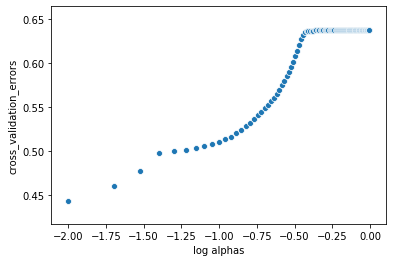

In [16]:
lasso_cv_table=pd.DataFrame(data=alphas)
lasso_cv_table = lasso_cv_table.rename({0:'alphas'},axis=1)
lasso_cv_table['cross_validation_errors']=validation_errors
lasso_min_cv = min(lasso_cv_table['cross_validation_errors'])
lasso_tuning = lasso_cv_table[lasso_cv_table['cross_validation_errors']==lasso_min_cv]['alphas'].values
lasso_cv_table['log alphas']=np.log10(alphas)
sns.scatterplot(x="log alphas",y="cross_validation_errors", data =lasso_cv_table)

In [17]:
final_lasso_linear_model = Lasso(fit_intercept = True, alpha=lasso_tuning)
final_lasso_linear_model.fit(X_train,Y_train)
lasso_coef = final_lasso_linear_model.coef_
lasso_intercept = final_lasso_linear_model.intercept_
columns = X.columns
lasso_table = pd.DataFrame(columns=["feature", "coefficient"])
lasso_table["feature"]=columns
lasso_table["coefficient"]=lasso_coef

In [18]:
#rounding predictions since they are only whole numbers
train_predictions = final_lasso_linear_model.predict(X_train)
train_predictions = np.around(train_predictions, decimals=0)
train_predictions = train_predictions.astype(int)
test_predictions = final_lasso_linear_model.predict(X_test)
test_predictions = np.around(test_predictions, decimals=0)
test_predictions = test_predictions.astype(int)
lasso_training_error=mse_cost(Y_train, train_predictions)
lasso_test_error=mse_cost(Y_test, test_predictions)

# Elastic Net Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||^2_2 + lambda * ||beta||_1 $ where alpha and lambda are the tuning parameters we will be finding using cross validation to minimize prediction error. Elastic net is combing the penalty functions from Lasso and Ridge regression

I am using scikit learn machine learning library built in elastic net regression model fitting. From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [19]:
alphas=np.arange(0.1,1,.1)
validation_errors =[]
for alpha in alphas:
    for beta in alphas:
        EN_linear_model = ElasticNet(alpha=alpha, l1_ratio=beta, fit_intercept = True)
        scores = cross_val_score(EN_linear_model, X_train, Y_train, cv=10,scoring='neg_mean_squared_error')
        validation_errors.append(np.mean(scores))
validation_errors=np.abs(validation_errors)

array([0.4762744 , 0.48415508, 0.49210262, 0.49953594, 0.50111751,
       0.50248895, 0.50404827, 0.5058087 , 0.50777681, 0.49291659,
       0.50314796, 0.50675136, 0.51061668, 0.51525386, 0.52072276,
       0.52708997, 0.53442868, 0.54171366, 0.50334223, 0.51130673,
       0.51793207, 0.5262214 , 0.53635519, 0.54725063, 0.55685408,
       0.56784263, 0.5806806 , 0.51150551, 0.52038592, 0.53139993,
       0.54537979, 0.55843044, 0.572335  , 0.58910279, 0.60923587,
       0.63220037, 0.51825769, 0.53030651, 0.5464153 , 0.56278587,
       0.58002567, 0.60134234, 0.62757685, 0.63610019, 0.6369651 ,
       0.52467147, 0.54070645, 0.56079481, 0.57975376, 0.60361322,
       0.63267736, 0.63650887, 0.63725058, 0.63727977, 0.53111056,
       0.55133758, 0.57319529, 0.59746071, 0.62863666, 0.6365108 ,
       0.6372882 , 0.63724819, 0.63722214, 0.53747878, 0.56186039,
       0.58560799, 0.61559986, 0.6361073 , 0.63725042, 0.63724811,
       0.637233  , 0.63732387, 0.54371589, 0.57087496, 0.59799

In [20]:
rpt_alphas=[]
for i in alphas:
    rpt_alphas.append(alphas)
rpt_alphas = np.concatenate(rpt_alphas)
rpt_l1=[]
for i in alphas:
    for j in alphas:
        rpt_l1.append(i)

In [21]:
EN_cv_table=pd.DataFrame(data=rpt_alphas)
EN_cv_table = EN_cv_table.rename({0:'alphas'},axis=1)
EN_cv_table['lambdas']=rpt_l1
EN_cv_table['cross_validation_errors']=validation_errors
EN_min_cv = min(EN_cv_table['cross_validation_errors'])
EN_tuning = EN_cv_table[EN_cv_table['cross_validation_errors']==EN_min_cv][['alphas', 'lambdas']].values
EN_alpha = EN_tuning[0,0]
EN_lambda = EN_tuning[0,1]

Text(0.5, 0, 'lambda')

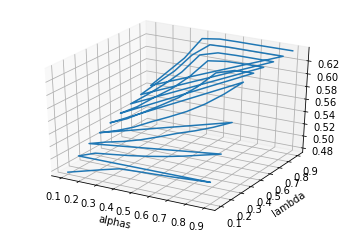

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=rpt_alphas
y=rpt_l1
z=validation_errors
ax.plot(x,y,z, label="Cross Validation Errors")
plt.xlabel('alphas')
plt.ylabel('lambda')

In [23]:
final_EN_linear_model = ElasticNet(fit_intercept = True, alpha=EN_alpha, l1_ratio=EN_lambda)
final_EN_linear_model.fit(X_train,Y_train)
EN_coef = final_EN_linear_model.coef_
EN_intercept = final_EN_linear_model.intercept_
columns = X.columns
EN_table = pd.DataFrame(columns=["feature", "coefficient"])
EN_table["feature"]=columns
EN_table["coefficient"]=EN_coef

In [24]:
#rounding predictions since they are only whole numbers
train_predictions = final_EN_linear_model.predict(X_train)
train_predictions = np.around(train_predictions, decimals=0)
train_predictions = train_predictions.astype(int)
test_predictions = final_EN_linear_model.predict(X_test)
test_predictions = np.around(test_predictions, decimals=0)
test_predictions = test_predictions.astype(int)
EN_training_error=mse_cost(Y_train, train_predictions)
EN_test_error=mse_cost(Y_test, test_predictions)

# Concise Portrayal of Information from Modeling
Concluding report of differing models

# OLS

In [25]:
print("OLS training error:",ols_training_error)
print("OLS test error:",ols_test_error)
print("Minimum cross validation error:",ols_min_cv)
print("OLS Intercept term:",ols_intercept)
OLS_table

OLS training error: 0.51772063933287
OLS test error: 0.375
Minimum cross validation error: 0.3634614680699564
OLS Intercept term: 11.886418041806401


,feature,coefficient
0,fixed acidity,0.019975
1,volatile acidity,-1.162244
2,citric acid,-0.190837
3,residual sugar,0.004013
4,chlorides,-1.836079
5,free sulfur dioxide,0.004501
6,total sulfur dioxide,-0.002901
7,density,-7.729597
8,pH,-0.410666
9,sulphates,0.865529


# Ridge:

Ridge training error: 0.5107713690062543
Ridge test error: 0.375
Minimum cross validation error: 0.43353387560561385
Ridge tuninng parameter alpha: [0.3]
Ridge Intercept term: 4.222308633353361


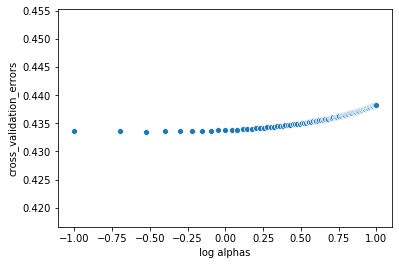

In [26]:
print("Ridge training error:",ridge_training_error)
print("Ridge test error:",ridge_test_error)
print("Minimum cross validation error:",ridge_min_cv)
print("Ridge tuninng parameter alpha:",ridge_tuning)
print("Ridge Intercept term:",ridge_intercept)
sns.scatterplot(x="log alphas",y="cross_validation_errors", data = ridge_cv_table)

In [27]:
ridge_table

,feature,coefficient
0,fixed acidity,0.014851
1,volatile acidity,-1.173424
2,citric acid,-0.199628
3,residual sugar,0.000318
4,chlorides,-1.615478
5,free sulfur dioxide,0.004551
6,total sulfur dioxide,-0.002884
7,density,-0.025600
8,pH,-0.425427
9,sulphates,0.826227


# Lasso:

Lasso training error: 0.5198054204308548
Lasso test error: 0.45
Minimum cross validation error: 0.44340340875545864
Lasso tuninng parameter alpha: [0.01]
Lasso Intercept term: 2.498848757075039


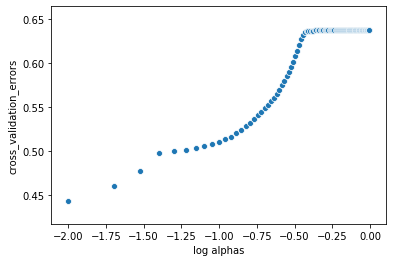

In [28]:
print("Lasso training error:",lasso_training_error)
print("Lasso test error:",lasso_test_error)
print("Minimum cross validation error:",lasso_min_cv)
print("Lasso tuninng parameter alpha:",lasso_tuning)
print("Lasso Intercept term:",lasso_intercept)
sns.scatterplot(x="log alphas",y="cross_validation_errors", data =lasso_cv_table)

In [29]:
lasso_table

,feature,coefficient
0,fixed acidity,0.034779
1,volatile acidity,-0.910448
2,citric acid,0.000000
3,residual sugar,-0.001435
4,chlorides,-0.000000
5,free sulfur dioxide,0.005061
6,total sulfur dioxide,-0.002845
7,density,-0.000000
8,pH,-0.000000
9,sulphates,0.362674


# Elastic Net:

Elastic Net training error: 0.5628908964558721
Elastic Net test error: 0.46875
Minimum cross validation error: 0.47627439820399725
Elastic Net tuninng parameter alpha: 0.1
Elastic Net tuninng parameter lambda: 0.1
Elastic Net Intercept term: 2.1149006099654573


Text(0.5, 0, 'lambda')

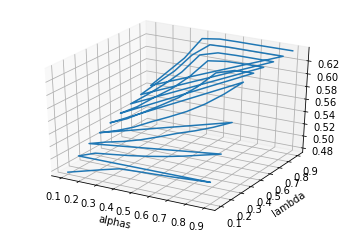

In [30]:
print("Elastic Net training error:",EN_training_error)
print("Elastic Net test error:",EN_test_error)
print("Minimum cross validation error:",EN_min_cv)
print("Elastic Net tuninng parameter alpha:",EN_alpha)
print("Elastic Net tuninng parameter lambda:",EN_lambda)
print("Elastic Net Intercept term:",EN_intercept)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=rpt_alphas
y=rpt_l1
z=validation_errors
ax.plot(x,y,z, label="Cross Validation Errors")
plt.xlabel('alphas')
plt.ylabel('lambda')

In [31]:
EN_table

,feature,coefficient
0,fixed acidity,0.054150
1,volatile acidity,-0.233872
2,citric acid,0.024922
3,residual sugar,-0.004832
4,chlorides,-0.000000
5,free sulfur dioxide,0.007004
6,total sulfur dioxide,-0.003365
7,density,-0.000000
8,pH,-0.000000
9,sulphates,0.122074
